In [6]:
import random
from datetime import datetime, timedelta
import csv

def generate_sales_data(start_date, end_date):
    data = []
    current_date = start_date
    base_sales = 30000
    growth_factor = 1.0002  # Slower growth factor for multi-year data

    while current_date <= end_date:
        # Basic daily sales with yearly growth
        years_passed = (current_date - start_date).days / 365.25
        daily_sales = base_sales * (growth_factor ** (years_passed * 365))

        # Add seasonal factor (higher in summer and winter)
        month = current_date.month
        if month in [6, 7, 8, 12, 1]:  # Summer and winter months
            daily_sales *= random.uniform(1.1, 1.3)
        elif month in [3, 4, 5, 9, 10, 11]:  # Spring and fall months
            daily_sales *= random.uniform(0.9, 1.1)
        else:
            daily_sales *= random.uniform(0.8, 1.0)

        # Add day of week factor (higher on weekends)
        if current_date.weekday() >= 5:  # Saturday and Sunday
            daily_sales *= random.uniform(1.1, 1.4)

        # Generate 1-3 orders for each day
        for _ in range(random.randint(1, 3)):
            sales = round(daily_sales * random.uniform(0.8, 1.2), 2)
            data.append((current_date.strftime("%Y-%m-%d"), sales))

        # Occasional outliers (about 5% chance)
        if random.random() < 0.05:
            outlier_sales = daily_sales * random.uniform(1.5, 3.0)
            data.append((current_date.strftime("%Y-%m-%d"), round(outlier_sales, 2)))

        current_date += timedelta(days=1)

    return data

# Generate data for multiple years (e.g., 5 years from 2020 to 2024)
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)
sales_data = generate_sales_data(start_date, end_date)

# Write data to a CSV file
with open('sales_data_2020_2024.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ORDERDATE", "SALES"])
    writer.writerows(sales_data)

print(f"Generated {len(sales_data)} sales records from {start_date.year} to {end_date.year}.")

Generated 3782 sales records from 2020 to 2024.


In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("sales_data_2020_2024.csv")
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df = df.sort_values('ORDERDATE')

def moving_average_analysis(df, window=3):
    df['MA'] = df['SALES'].rolling(window=window).mean()
    df['MA_diff'] = abs(df['SALES'] - df['MA']) / df['MA']
    df['MA_flag'] = df['MA_diff'] > 0.5  # Flag if difference is more than 50%
    return df

def z_score_analysis(df):
    df['Z_score'] = stats.zscore(df['SALES'])
    df['Z_flag'] = abs(df['Z_score']) > 2  # Flag if Z-score is more than 2
    return df

def iqr_analysis(df):
    Q1 = df['SALES'].quantile(0.25)
    Q3 = df['SALES'].quantile(0.75)
    IQR = Q3 - Q1
    df['IQR_flag'] = (df['SALES'] < (Q1 - 1.5 * IQR)) | (df['SALES'] > (Q3 + 1.5 * IQR))
    return df

def time_series_decomposition(df):
    # Resample to daily data for decomposition
    daily_sales = df.resample('D', on='ORDERDATE')['SALES'].sum().fillna(0)
    result = seasonal_decompose(daily_sales, model='additive', period=7)
    
    df['Trend'] = result.trend.reindex(df.index)
    df['Seasonal'] = result.seasonal.reindex(df.index)
    df['Residual'] = result.resid.reindex(df.index)
    
    # Flag large residuals
    df['Residual_flag'] = abs(df['Residual']) > df['Residual'].std() * 2
    return df

def cluster_analysis(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['SALES']])
    kmeans = KMeans(n_clusters=2, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    
    # Flag the cluster with fewer points as potential anomalies
    smaller_cluster = df['Cluster'].value_counts().idxmin()
    df['Cluster_flag'] = df['Cluster'] == smaller_cluster
    return df

def benford_analysis(df):
    first_digits = df['SALES'].astype(str).str[0].astype(int)
    observed_freq = first_digits.value_counts().sort_index() / len(first_digits)
    
    expected_freq = pd.Series({d: np.log10(1 + 1/d) for d in range(1, 10)})
    
    chi_square_stat = ((observed_freq - expected_freq)**2 / expected_freq).sum()
    p_value = 1 - stats.chi2.cdf(chi_square_stat, df=8)
    
    df['Benford_flag'] = p_value < 0.05  # Flag if Benford's Law is violated
    return df, p_value

def combine_flags(df):
    flag_columns = [col for col in df.columns if col.endswith('_flag')]
    df['Total_flags'] = df[flag_columns].sum(axis=1)
    return df

# Apply all methods
df = moving_average_analysis(df)
df = z_score_analysis(df)
df = iqr_analysis(df)
df = time_series_decomposition(df)
df = cluster_analysis(df)
df, benford_p_value = benford_analysis(df)
df = combine_flags(df)

print(df)
print(f"\nBenford's Law p-value: {benford_p_value}")

# Identify high-risk transactions
high_risk = df[df['Total_flags'] >= 2]
print("\nHigh-risk transactions (2 or more flags):")
print(high_risk[['ORDERDATE', 'SALES', 'Total_flags']])

      ORDERDATE     SALES            MA   MA_diff  MA_flag   Z_score  Z_flag  \
0    2020-01-01  40416.02           NaN       NaN    False -0.210790   False   
1    2020-01-01  43677.42           NaN       NaN    False  0.039258   False   
2    2020-01-01  38317.00  40803.480000  0.060938    False -0.371720   False   
3    2020-01-02  38477.80  40157.406667  0.041826    False -0.359392   False   
4    2020-01-03  36236.82  37677.206667  0.038230    False -0.531205   False   
...         ...       ...           ...       ...      ...       ...     ...   
3777 2024-12-28  62415.42  64167.510000  0.027305    False  1.475881   False   
3778 2024-12-29  70660.80  65571.793333  0.077610    False  2.108046    True   
3779 2024-12-30  45101.78  59392.666667  0.240617    False  0.148462   False   
3780 2024-12-31  56848.62  57537.066667  0.011965    False  1.049080   False   
3781 2024-12-31  42546.91  48165.770000  0.116657    False -0.047417   False   

      IQR_flag  Trend  Seasonal  Residu

c:\Users\ysyss\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


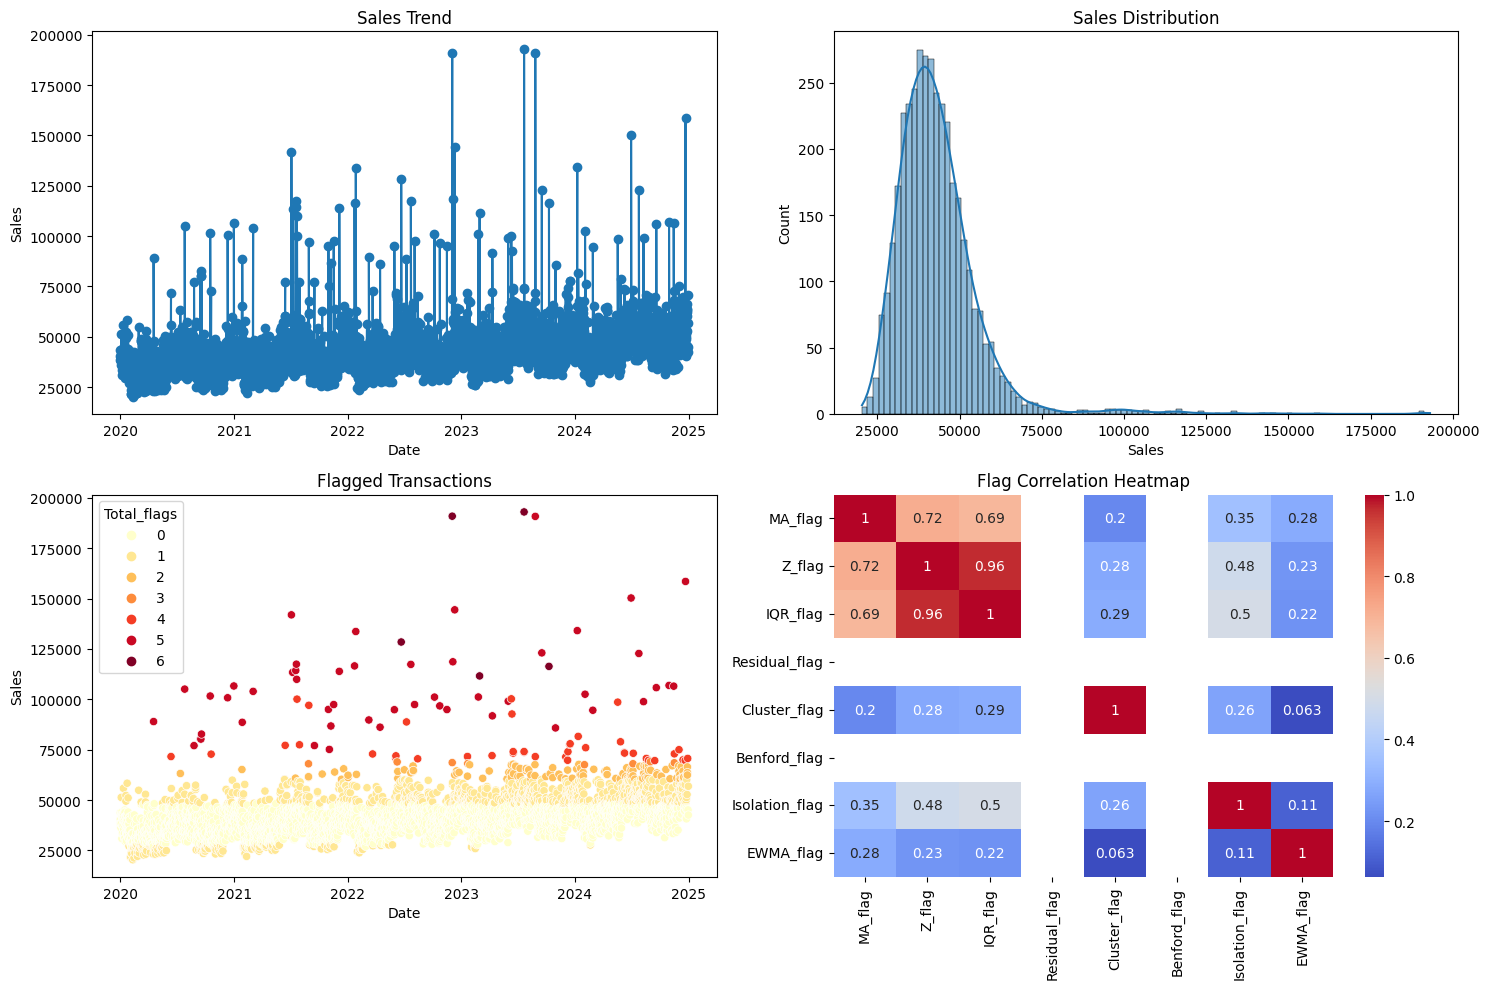

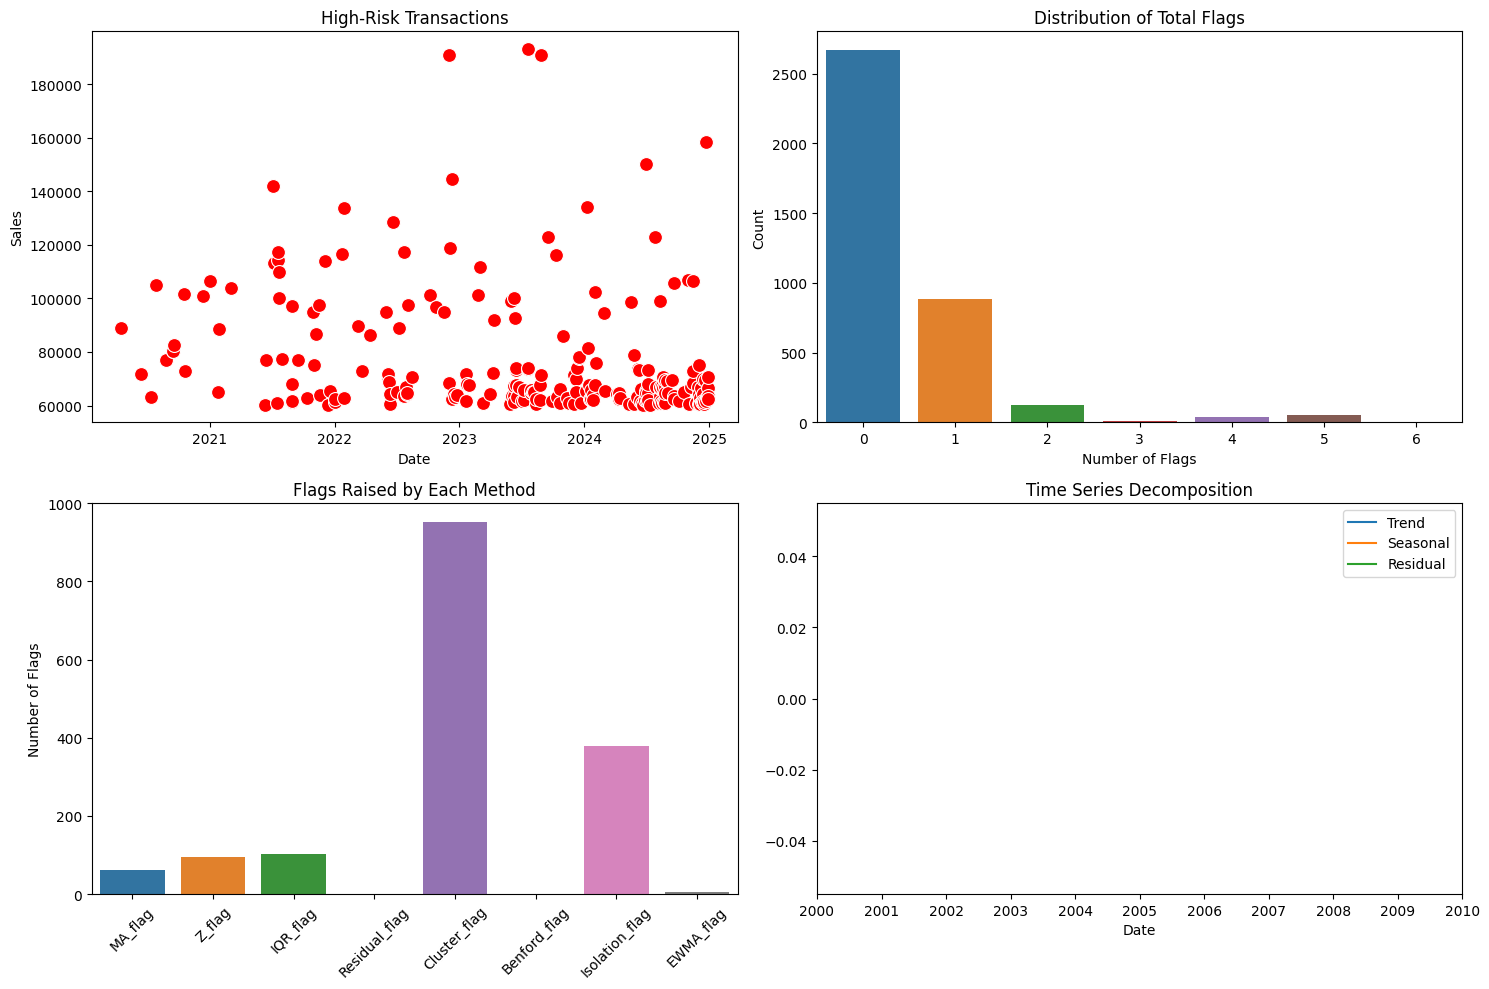

      ORDERDATE     SALES            MA   MA_diff  MA_flag   Z_score  Z_flag  \
0    2020-01-01  40416.02           NaN       NaN    False -0.210790   False   
1    2020-01-01  43677.42           NaN       NaN    False  0.039258   False   
2    2020-01-01  38317.00  40803.480000  0.060938    False -0.371720   False   
3    2020-01-02  38477.80  40157.406667  0.041826    False -0.359392   False   
4    2020-01-03  36236.82  37677.206667  0.038230    False -0.531205   False   
...         ...       ...           ...       ...      ...       ...     ...   
3777 2024-12-28  62415.42  64167.510000  0.027305    False  1.475881   False   
3778 2024-12-29  70660.80  65571.793333  0.077610    False  2.108046    True   
3779 2024-12-30  45101.78  59392.666667  0.240617    False  0.148462   False   
3780 2024-12-31  56848.62  57537.066667  0.011965    False  1.049080   False   
3781 2024-12-31  42546.91  48165.770000  0.116657    False -0.047417   False   

      IQR_flag  Trend  Seasonal  Residu

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns


# Load data
df = pd.read_csv("sales_data_2020_2024.csv")
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df = df.sort_values('ORDERDATE')

# Existing methods (from previous script)
def moving_average_analysis(df, window=3):
    df['MA'] = df['SALES'].rolling(window=window).mean()
    df['MA_diff'] = abs(df['SALES'] - df['MA']) / df['MA']
    df['MA_flag'] = df['MA_diff'] > 0.5
    return df

def z_score_analysis(df):
    df['Z_score'] = stats.zscore(df['SALES'])
    df['Z_flag'] = abs(df['Z_score']) > 2
    return df

def iqr_analysis(df):
    Q1 = df['SALES'].quantile(0.25)
    Q3 = df['SALES'].quantile(0.75)
    IQR = Q3 - Q1
    df['IQR_flag'] = (df['SALES'] < (Q1 - 1.5 * IQR)) | (df['SALES'] > (Q3 + 1.5 * IQR))
    return df

def time_series_decomposition(df):
    daily_sales = df.resample('D', on='ORDERDATE')['SALES'].sum().fillna(0)
    result = seasonal_decompose(daily_sales, model='additive', period=7)
    df['Trend'] = result.trend.reindex(df.index)
    df['Seasonal'] = result.seasonal.reindex(df.index)
    df['Residual'] = result.resid.reindex(df.index)
    df['Residual_flag'] = abs(df['Residual']) > df['Residual'].std() * 2
    return df

def cluster_analysis(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['SALES']])
    kmeans = KMeans(n_clusters=2, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    smaller_cluster = df['Cluster'].value_counts().idxmin()
    df['Cluster_flag'] = df['Cluster'] == smaller_cluster
    return df

def benford_analysis(df):
    first_digits = df['SALES'].astype(str).str[0].astype(int)
    observed_freq = first_digits.value_counts().sort_index() / len(first_digits)
    expected_freq = pd.Series({d: np.log10(1 + 1/d) for d in range(1, 10)})
    chi_square_stat = ((observed_freq - expected_freq)**2 / expected_freq).sum()
    p_value = 1 - stats.chi2.cdf(chi_square_stat, df=8)
    df['Benford_flag'] = p_value < 0.05
    return df, p_value

# New methods
def isolation_forest_analysis(df):
    X = df[['SALES']].values
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    df['Isolation_flag'] = iso_forest.fit_predict(X) == -1
    return df

def ewma_analysis(df, span=3):
    df['EWMA'] = df['SALES'].ewm(span=span).mean()
    df['EWMA_diff'] = abs(df['SALES'] - df['EWMA']) / df['EWMA']
    df['EWMA_flag'] = df['EWMA_diff'] > 0.5
    return df

def combine_flags(df):
    flag_columns = [col for col in df.columns if col.endswith('_flag')]
    df['Total_flags'] = df[flag_columns].sum(axis=1)
    return df

# Apply all methods
df = moving_average_analysis(df)
df = z_score_analysis(df)
df = iqr_analysis(df)
df = time_series_decomposition(df)
df = cluster_analysis(df)
df, benford_p_value = benford_analysis(df)
df = isolation_forest_analysis(df)
df = ewma_analysis(df)
df = combine_flags(df)

# Visualizations
plt.figure(figsize=(15, 10))

# 1. Overall Sales Trend
plt.subplot(2, 2, 1)
plt.plot(df['ORDERDATE'], df['SALES'], marker='o')
plt.title('Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')

# 2. Sales Distribution
plt.subplot(2, 2, 2)
sns.histplot(df['SALES'], kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales')

# 3. Flagged Transactions
plt.subplot(2, 2, 3)
sns.scatterplot(x='ORDERDATE', y='SALES', hue='Total_flags', data=df, palette='YlOrRd')
plt.title('Flagged Transactions')
plt.xlabel('Date')
plt.ylabel('Sales')

# 4. Flag Correlation Heatmap
plt.subplot(2, 2, 4)
flag_cols = [col for col in df.columns if col.endswith('_flag')]
sns.heatmap(df[flag_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Flag Correlation Heatmap')

plt.tight_layout()
plt.show()

# Additional Visualizations for Flagged Transactions
high_risk = df[df['Total_flags'] >= 2]

plt.figure(figsize=(15, 10))

# 5. High-Risk Transactions
plt.subplot(2, 2, 1)
sns.scatterplot(x='ORDERDATE', y='SALES', data=high_risk, s=100, color='red')
plt.title('High-Risk Transactions')
plt.xlabel('Date')
plt.ylabel('Sales')

# 6. Flag Distribution
plt.subplot(2, 2, 2)
sns.countplot(x='Total_flags', data=df)
plt.title('Distribution of Total Flags')
plt.xlabel('Number of Flags')
plt.ylabel('Count')

# 7. Method Comparison
plt.subplot(2, 2, 3)
flag_counts = df[flag_cols].sum()
sns.barplot(x=flag_counts.index, y=flag_counts.values)
plt.title('Flags Raised by Each Method')
plt.xticks(rotation=45)
plt.ylabel('Number of Flags')

# 8. Time Series Decomposition
plt.subplot(2, 2, 4)
plt.plot(df['ORDERDATE'], df['Trend'], label='Trend')
plt.plot(df['ORDERDATE'], df['Seasonal'], label='Seasonal')
plt.plot(df['ORDERDATE'], df['Residual'], label='Residual')
plt.title('Time Series Decomposition')
plt.xlabel('Date')
plt.legend()

plt.tight_layout()
plt.show()

print(df)
print(f"\nBenford's Law p-value: {benford_p_value}")
print("\nHigh-risk transactions (2 or more flags):")
print(high_risk[['ORDERDATE', 'SALES', 'Total_flags']])

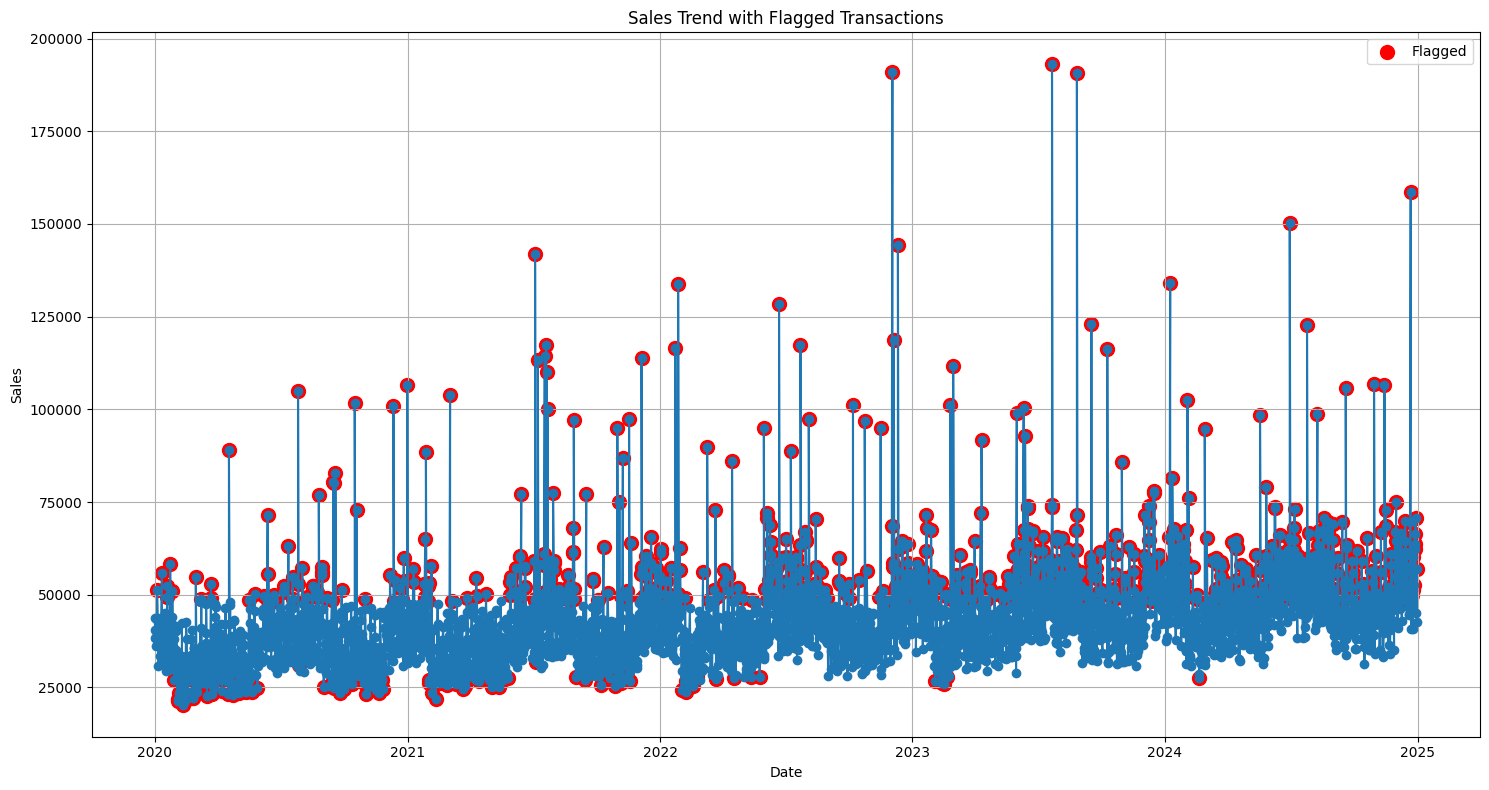

c:\Users\ysyss\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


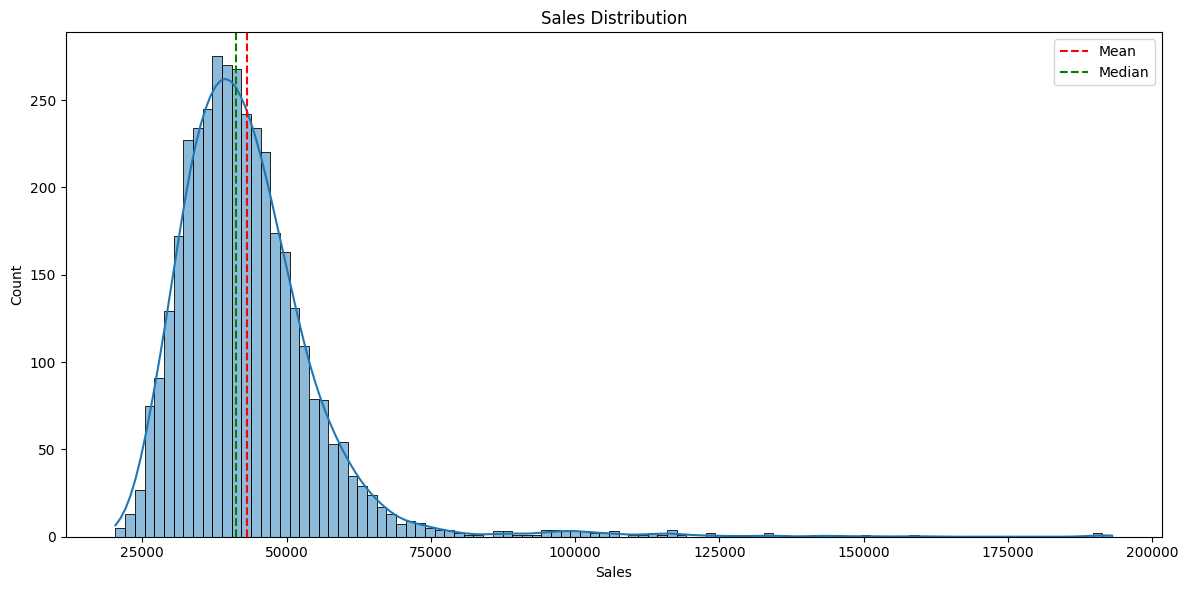

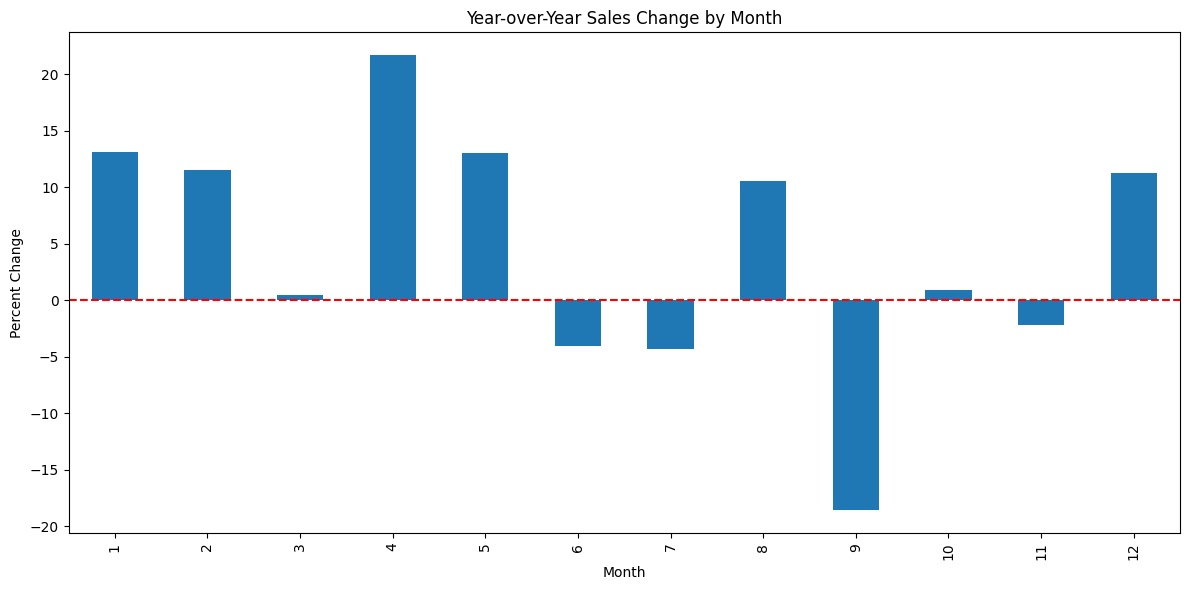

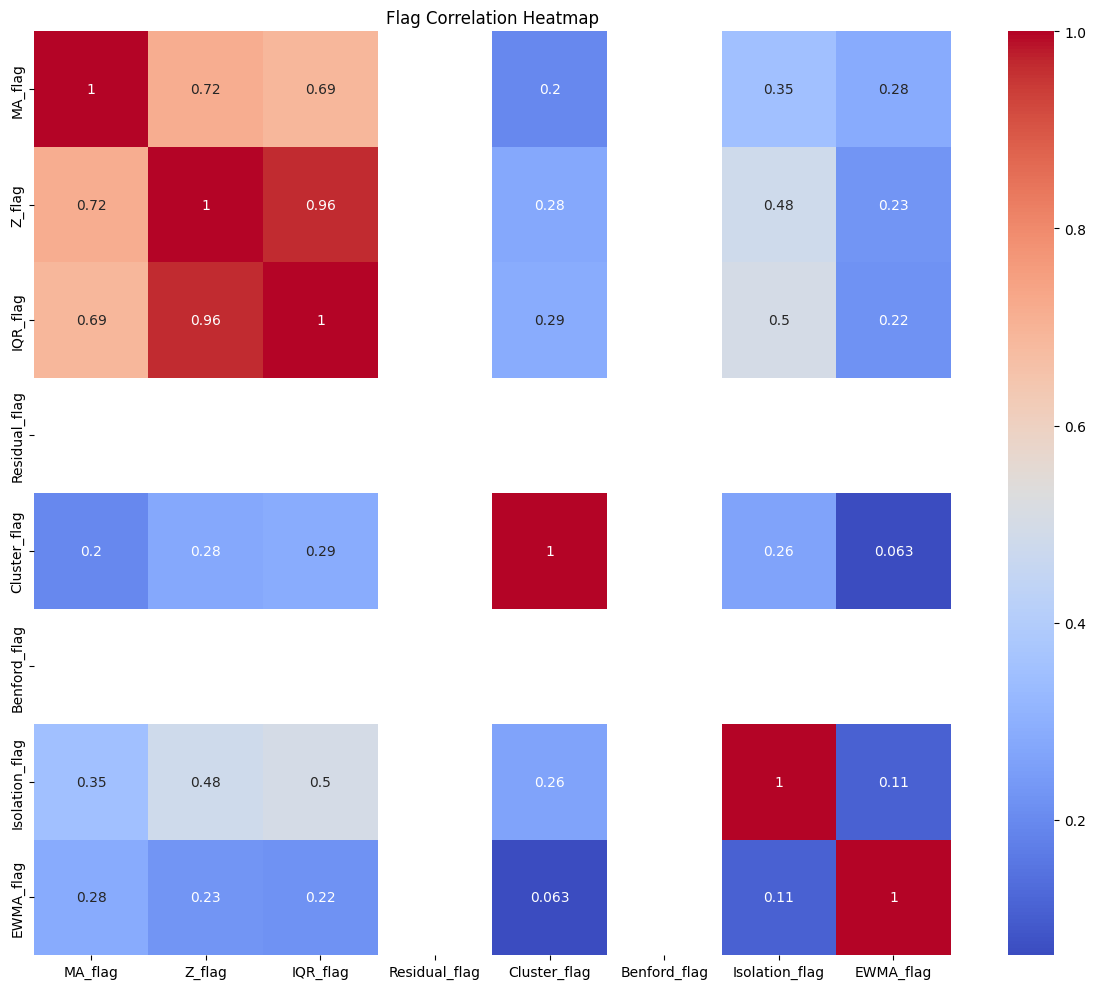

Summary Statistics:
count      3782.000000
mean      43165.374730
std       13044.811838
min       20345.690000
25%       35226.432500
50%       41294.605000
75%       48331.137500
max      193040.560000
Name: SALES, dtype: float64

Benford's Law p-value: 0.990087875394676

Flagged Transactions:
      ORDERDATE      SALES  Total_flags
2688 2023-07-22  193040.56            6
2870 2023-10-10  116362.08            6
1877 2022-06-22  128463.84            6
2396 2023-03-01  111617.39            6
2201 2022-12-03  190935.64            6
...         ...        ...          ...
1974 2022-08-06   51020.90            1
1982 2022-08-11   51564.03            1
1983 2022-08-11   52089.60            1
1984 2022-08-11   52955.67            1
3780 2024-12-31   56848.62            1

[1112 rows x 3 columns]

Year-over-Year Monthly Sales Change (%):
Month
1     13.110833
2     11.509015
3      0.468932
4     21.704891
5     13.069872
6     -4.069503
7     -4.257473
8     10.589263
9    -18.561467
10    

In [12]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace this with your actual data)
data = '''ORDERDATE,SALES
2022-01-02,18000.00
2022-01-03,22000.00
2022-02-01,19000.00
2022-02-02,21000.00
2023-01-02,20353.78
2023-01-03,15743.93
2023-01-03,46834.84
2023-01-12,80817.79
2023-01-13,20495.36
2023-01-14,12901.71
2023-02-01,22000.00
2023-02-02,23000.00'''

# Load data
df = pd.read_csv("sales_data_2020_2024.csv")
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df = df.sort_values('ORDERDATE')

# Analysis functions
def moving_average_analysis(df, window=3):
    df['MA'] = df['SALES'].rolling(window=window).mean()
    df['MA_diff'] = abs(df['SALES'] - df['MA']) / df['MA']
    df['MA_flag'] = df['MA_diff'] > 0.5
    return df

def z_score_analysis(df):
    df['Z_score'] = stats.zscore(df['SALES'])
    df['Z_flag'] = abs(df['Z_score']) > 2
    return df

def iqr_analysis(df):
    Q1 = df['SALES'].quantile(0.25)
    Q3 = df['SALES'].quantile(0.75)
    IQR = Q3 - Q1
    df['IQR_flag'] = (df['SALES'] < (Q1 - 1.5 * IQR)) | (df['SALES'] > (Q3 + 1.5 * IQR))
    return df

def time_series_decomposition(df):
    daily_sales = df.set_index('ORDERDATE')['SALES'].resample('D').sum().fillna(0)
    if len(daily_sales) > 7:  # Need at least 2 periods for decomposition
        result = seasonal_decompose(daily_sales, model='additive', period=7)
        df['Trend'] = result.trend.reindex(df.index)
        df['Seasonal'] = result.seasonal.reindex(df.index)
        df['Residual'] = result.resid.reindex(df.index)
        df['Residual_flag'] = abs(df['Residual']) > df['Residual'].std() * 2
    else:
        df['Trend'] = df['Seasonal'] = df['Residual'] = df['Residual_flag'] = np.nan
    return df

def cluster_analysis(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['SALES']])
    kmeans = KMeans(n_clusters=2, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    smaller_cluster = df['Cluster'].value_counts().idxmin()
    df['Cluster_flag'] = df['Cluster'] == smaller_cluster
    return df

def benford_analysis(df):
    first_digits = df['SALES'].astype(str).str[0].astype(int)
    observed_freq = first_digits.value_counts().sort_index() / len(first_digits)
    expected_freq = pd.Series({d: np.log10(1 + 1/d) for d in range(1, 10)})
    chi_square_stat = ((observed_freq - expected_freq)**2 / expected_freq).sum()
    p_value = 1 - stats.chi2.cdf(chi_square_stat, df=8)
    df['Benford_flag'] = p_value < 0.05
    return df, p_value

def isolation_forest_analysis(df):
    X = df[['SALES']].values
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    df['Isolation_flag'] = iso_forest.fit_predict(X) == -1
    return df

def ewma_analysis(df, span=3):
    df['EWMA'] = df['SALES'].ewm(span=span).mean()
    df['EWMA_diff'] = abs(df['SALES'] - df['EWMA']) / df['EWMA']
    df['EWMA_flag'] = df['EWMA_diff'] > 0.5
    return df

def year_over_year_comparison(df):
    df['Year'] = df['ORDERDATE'].dt.year
    df['Month'] = df['ORDERDATE'].dt.month
    monthly_sales = df.groupby(['Year', 'Month'])['SALES'].sum().unstack(level=0)
    yoy_change = (monthly_sales[monthly_sales.columns[-1]] / monthly_sales[monthly_sales.columns[-2]] - 1) * 100
    return yoy_change

def combine_flags(df):
    flag_columns = [col for col in df.columns if col.endswith('_flag')]
    df['Total_flags'] = df[flag_columns].sum(axis=1)
    return df

# Apply all methods
df = moving_average_analysis(df)
df = z_score_analysis(df)
df = iqr_analysis(df)
df = time_series_decomposition(df)
df = cluster_analysis(df)
df, benford_p_value = benford_analysis(df)
df = isolation_forest_analysis(df)
df = ewma_analysis(df)
df = combine_flags(df)
yoy_change = year_over_year_comparison(df)

# Visualization functions
def plot_sales_trend_with_flags(df):
    plt.figure(figsize=(15, 8))
    plt.plot(df['ORDERDATE'], df['SALES'], marker='o')
    flagged = df[df['Total_flags'] > 0]
    plt.scatter(flagged['ORDERDATE'], flagged['SALES'], color='red', s=100, label='Flagged')
    plt.title('Sales Trend with Flagged Transactions')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_sales_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['SALES'], kde=True)
    plt.title('Sales Distribution')
    plt.xlabel('Sales')
    plt.axvline(df['SALES'].mean(), color='r', linestyle='--', label='Mean')
    plt.axvline(df['SALES'].median(), color='g', linestyle='--', label='Median')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_yoy_comparison(yoy_change):
    plt.figure(figsize=(12, 6))
    yoy_change.plot(kind='bar')
    plt.title('Year-over-Year Sales Change by Month')
    plt.xlabel('Month')
    plt.ylabel('Percent Change')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

def plot_flag_correlation(df):
    flag_cols = [col for col in df.columns if col.endswith('_flag')]
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[flag_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Flag Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Generate visualizations
plot_sales_trend_with_flags(df)
plot_sales_distribution(df)
plot_yoy_comparison(yoy_change)
plot_flag_correlation(df)

# Print summary statistics and flagged transactions
print("Summary Statistics:")
print(df['SALES'].describe())

print("\nBenford's Law p-value:", benford_p_value)

print("\nFlagged Transactions:")
flagged_transactions = df[df['Total_flags'] > 0].sort_values('Total_flags', ascending=False)
print(flagged_transactions[['ORDERDATE', 'SALES', 'Total_flags']])

print("\nYear-over-Year Monthly Sales Change (%):")
print(yoy_change)

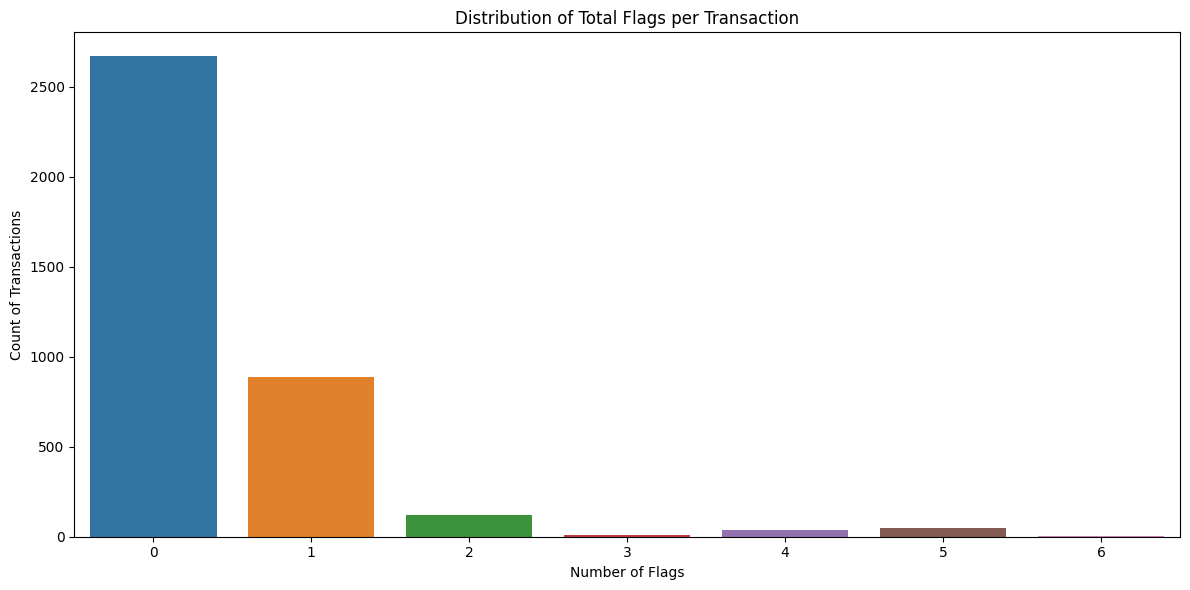

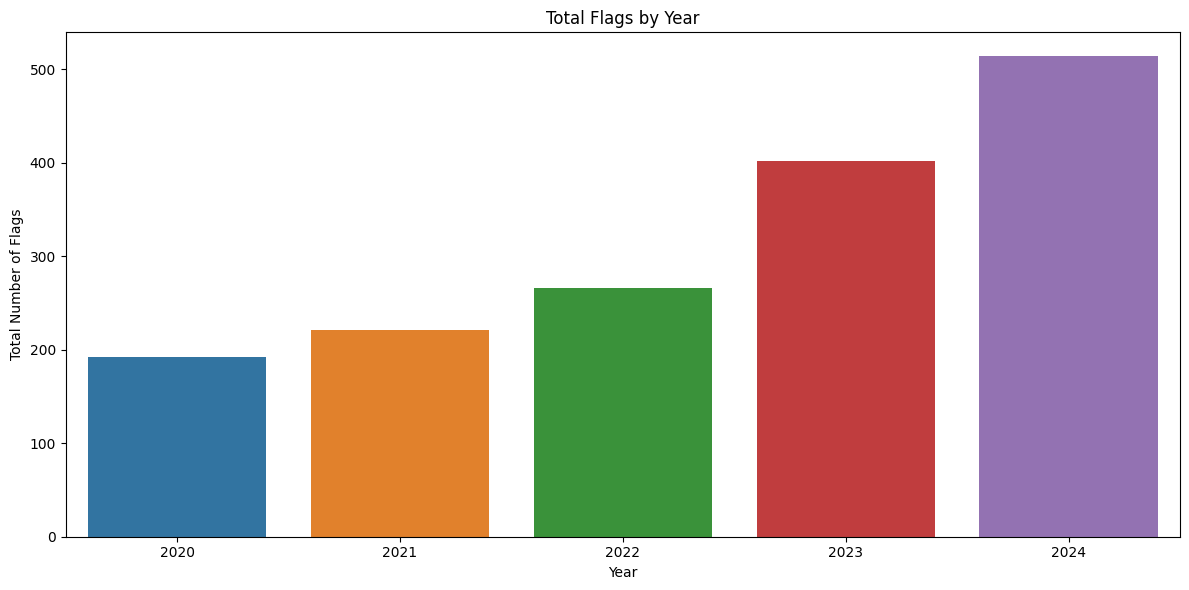

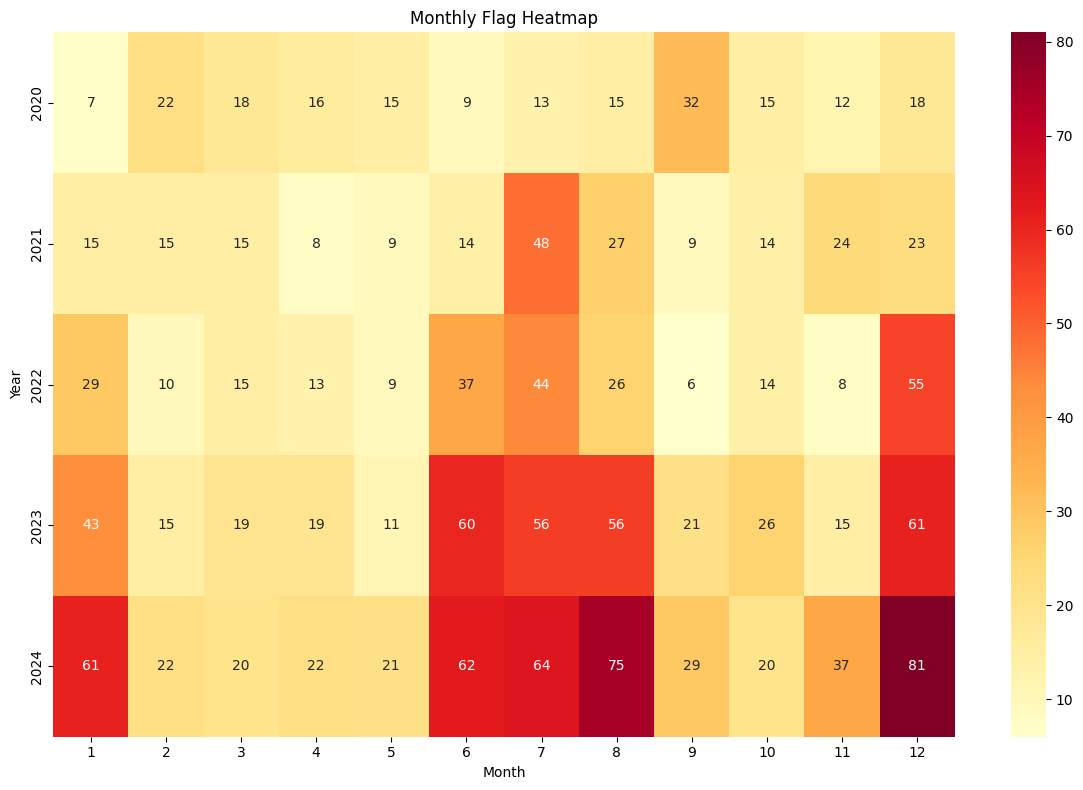

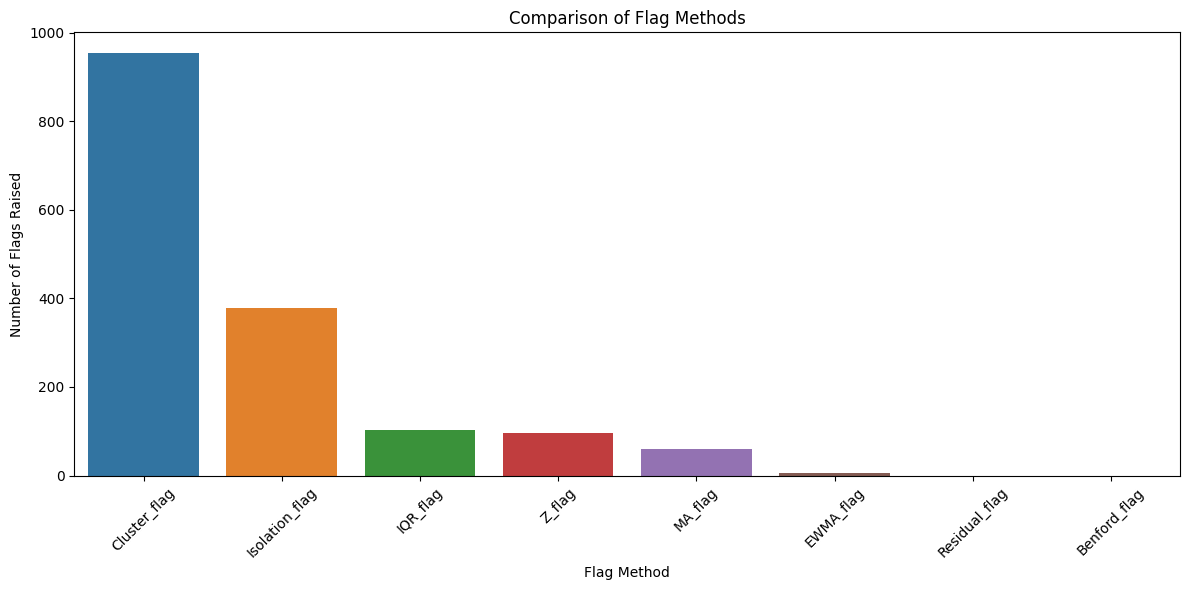

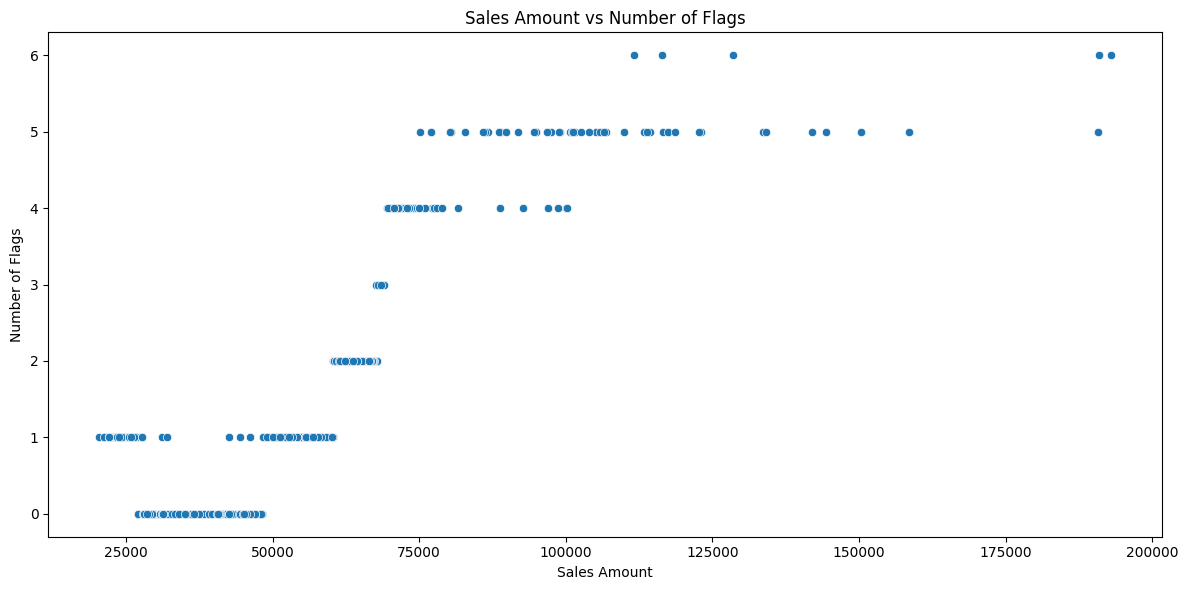

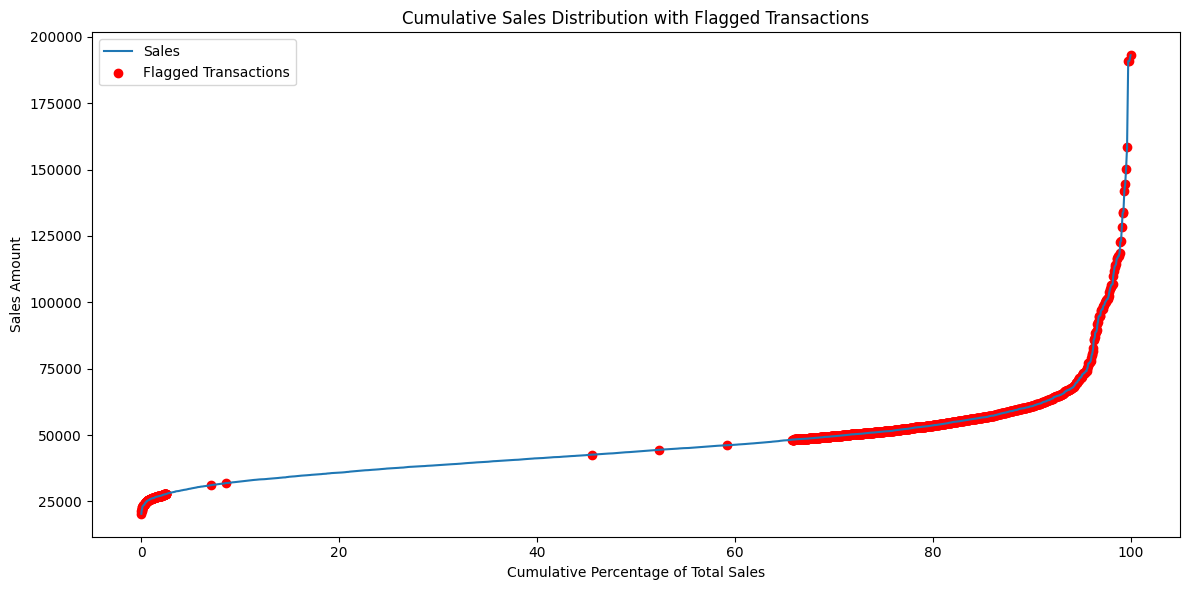

Summary Statistics:
count      3782.000000
mean      43165.374730
std       13044.811838
min       20345.690000
25%       35226.432500
50%       41294.605000
75%       48331.137500
max      193040.560000
Name: SALES, dtype: float64

Benford's Law p-value: 0.990087875394676

Flagged Transactions:
      ORDERDATE      SALES  Total_flags
2688 2023-07-22  193040.56            6
2870 2023-10-10  116362.08            6
1877 2022-06-22  128463.84            6
2396 2023-03-01  111617.39            6
2201 2022-12-03  190935.64            6
...         ...        ...          ...
1974 2022-08-06   51020.90            1
1982 2022-08-11   51564.03            1
1983 2022-08-11   52089.60            1
1984 2022-08-11   52955.67            1
3780 2024-12-31   56848.62            1

[1112 rows x 3 columns]

Year-over-Year Monthly Sales Change (%):
Month
1     13.110833
2     11.509015
3      0.468932
4     21.704891
5     13.069872
6     -4.069503
7     -4.257473
8     10.589263
9    -18.561467
10    

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("sales_data_2020_2024.csv")
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df = df.sort_values('ORDERDATE')

# Analysis functions
def moving_average_analysis(df, window=3):
    df['MA'] = df['SALES'].rolling(window=window).mean()
    df['MA_diff'] = abs(df['SALES'] - df['MA']) / df['MA']
    df['MA_flag'] = df['MA_diff'] > 0.5
    return df

def z_score_analysis(df):
    df['Z_score'] = stats.zscore(df['SALES'])
    df['Z_flag'] = abs(df['Z_score']) > 2
    return df

def iqr_analysis(df):
    Q1 = df['SALES'].quantile(0.25)
    Q3 = df['SALES'].quantile(0.75)
    IQR = Q3 - Q1
    df['IQR_flag'] = (df['SALES'] < (Q1 - 1.5 * IQR)) | (df['SALES'] > (Q3 + 1.5 * IQR))
    return df

def time_series_decomposition(df):
    daily_sales = df.set_index('ORDERDATE')['SALES'].resample('D').sum().fillna(0)
    if len(daily_sales) > 7:  # Need at least 2 periods for decomposition
        result = seasonal_decompose(daily_sales, model='additive', period=7)
        df['Trend'] = result.trend.reindex(df.index)
        df['Seasonal'] = result.seasonal.reindex(df.index)
        df['Residual'] = result.resid.reindex(df.index)
        df['Residual_flag'] = abs(df['Residual']) > df['Residual'].std() * 2
    else:
        df['Trend'] = df['Seasonal'] = df['Residual'] = df['Residual_flag'] = np.nan
    return df

def cluster_analysis(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['SALES']])
    kmeans = KMeans(n_clusters=2, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    smaller_cluster = df['Cluster'].value_counts().idxmin()
    df['Cluster_flag'] = df['Cluster'] == smaller_cluster
    return df

def benford_analysis(df):
    first_digits = df['SALES'].astype(str).str[0].astype(int)
    observed_freq = first_digits.value_counts().sort_index() / len(first_digits)
    expected_freq = pd.Series({d: np.log10(1 + 1/d) for d in range(1, 10)})
    chi_square_stat = ((observed_freq - expected_freq)**2 / expected_freq).sum()
    p_value = 1 - stats.chi2.cdf(chi_square_stat, df=8)
    df['Benford_flag'] = p_value < 0.05
    return df, p_value

def isolation_forest_analysis(df):
    X = df[['SALES']].values
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    df['Isolation_flag'] = iso_forest.fit_predict(X) == -1
    return df

def ewma_analysis(df, span=3):
    df['EWMA'] = df['SALES'].ewm(span=span).mean()
    df['EWMA_diff'] = abs(df['SALES'] - df['EWMA']) / df['EWMA']
    df['EWMA_flag'] = df['EWMA_diff'] > 0.5
    return df

def year_over_year_comparison(df):
    df['Year'] = df['ORDERDATE'].dt.year
    df['Month'] = df['ORDERDATE'].dt.month
    monthly_sales = df.groupby(['Year', 'Month'])['SALES'].sum().unstack(level=0)
    yoy_change = (monthly_sales[monthly_sales.columns[-1]] / monthly_sales[monthly_sales.columns[-2]] - 1) * 100
    return yoy_change

def combine_flags(df):
    flag_columns = [col for col in df.columns if col.endswith('_flag')]
    df['Total_flags'] = df[flag_columns].sum(axis=1)
    return df

# Apply all methods
df = moving_average_analysis(df)
df = z_score_analysis(df)
df = iqr_analysis(df)
df = time_series_decomposition(df)
df = cluster_analysis(df)
df, benford_p_value = benford_analysis(df)
df = isolation_forest_analysis(df)
df = ewma_analysis(df)
df = combine_flags(df)
yoy_change = year_over_year_comparison(df)

# Add year and month columns for analysis
df['Year'] = df['ORDERDATE'].dt.year
df['Month'] = df['ORDERDATE'].dt.month

# Enhanced visualization functions
def plot_flag_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='Total_flags', data=df)
    plt.title('Distribution of Total Flags per Transaction')
    plt.xlabel('Number of Flags')
    plt.ylabel('Count of Transactions')
    plt.tight_layout()
    plt.show()

def plot_yearly_flag_comparison(df):
    yearly_flags = df.groupby('Year')['Total_flags'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Year', y='Total_flags', data=yearly_flags)
    plt.title('Total Flags by Year')
    plt.xlabel('Year')
    plt.ylabel('Total Number of Flags')
    plt.tight_layout()
    plt.show()

def plot_monthly_flag_heatmap(df):
    monthly_flags = df.groupby(['Year', 'Month'])['Total_flags'].sum().unstack()
    plt.figure(figsize=(12, 8))
    sns.heatmap(monthly_flags, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Monthly Flag Heatmap')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.show()

def plot_flag_method_comparison(df):
    flag_cols = [col for col in df.columns if col.endswith('_flag')]
    flag_counts = df[flag_cols].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=flag_counts.index, y=flag_counts.values)
    plt.title('Comparison of Flag Methods')
    plt.xlabel('Flag Method')
    plt.ylabel('Number of Flags Raised')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_sales_vs_flags_scatter(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='SALES', y='Total_flags', data=df)
    plt.title('Sales Amount vs Number of Flags')
    plt.xlabel('Sales Amount')
    plt.ylabel('Number of Flags')
    plt.tight_layout()
    plt.show()

# def plot_cumulative_sales_with_flags(df):
#     df_sorted = df.sort_values('SALES')
#     df_sorted['Cumulative_Sales'] = df_sorted['SALES'].cumsum()
#     df_sorted['Cumulative_Sales_Percentage'] = df_sorted['Cumulative_Sales'] / df_sorted['SALES'].sum() * 100
    
#     plt.figure(figsize=(12, 6))
#     plt.plot(df_sorted['Cumulative_Sales_Percentage'], df_sorted['SALES'], label='Sales')
#     flagged = df_sorted[df_sorted['Total_flags'] > 0]
#     plt.scatter(flagged['Cumulative_Sales_Percentage'], flagged['SALES'], color='red', label='Flagged Transactions')
#     plt.title('Cumulative Sales Distribution with Flagged Transactions')
#     plt.xlabel('Cumulative Percentage of Total Sales')
#     plt.ylabel('Sales Amount')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# Generate enhanced visualizations
plot_flag_distribution(df)
plot_yearly_flag_comparison(df)
plot_monthly_flag_heatmap(df)
plot_flag_method_comparison(df)
plot_sales_vs_flags_scatter(df)
plot_cumulative_sales_with_flags(df)

# Print summary statistics and flagged transactions
print("Summary Statistics:")
print(df['SALES'].describe())

print("\nBenford's Law p-value:", benford_p_value)

print("\nFlagged Transactions:")
flagged_transactions = df[df['Total_flags'] > 0].sort_values('Total_flags', ascending=False)
print(flagged_transactions[['ORDERDATE', 'SALES', 'Total_flags']])

print("\nYear-over-Year Monthly Sales Change (%):")
print(yoy_change)

print("\nFlag Summary:")
print(f"Total number of transactions: {len(df)}")
print(f"Number of flagged transactions: {df['Total_flags'].sum()}")
print(f"Percentage of flagged transactions: {(df['Total_flags'].sum() / len(df)) * 100:.2f}%")

print("\nTop 5 Most Flagged Transactions:")
print(df.nlargest(5, 'Total_flags')[['ORDERDATE', 'SALES', 'Total_flags']])

print("\nMonthly Flag Counts:")
print(df.groupby(['Year', 'Month'])['Total_flags'].sum().unstack())